In [15]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [16]:
# directory & file hierarchy
iterationName = 'CDMphotodraw_pilot'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches_CDM')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [17]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['CDM_photodraw_pilot']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [18]:
# experiment_name = 'CDM_photodraw_pilot'
experiment_name = 'CDM_photodraw_pilot'

all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find().distinct('sessionId')
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)


We currently have 5 valid sessions from CDM_photodraw_pilot.


In [54]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    kidName = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    age=[]
    countErr = 0
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:                                                            
                stroke_recs = this_collection.find({'$and': [ 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   
                
                if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                    session_id.append(imrec['sessionId'])        
                    trial_num.append(imrec['trialNum']) 
                    category.append(imrec['category'])
                    
                    
                    try:    
                        png.append(imrec['imgData'])
                        submit_time.append(imrec['time'])
                        submit_date.append(imrec['date'])
                        age.append(imrec['age'])
                        filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['sessionId'], imrec['condition'])))
                        num_strokes.append(stroke_recs.count())
                        _svg = [] # this keeps track of the strokes from THIS final image
                        _svg_times = []
                        for strec in stroke_recs:
                            _svg.append(strec['svg'])
                            _svg_times.append(strec['time'])
                        draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                        svg.append(_svg)
                        svg_times.append(_svg_times)

                        ## and write out image data here too
                        imgData = imrec['imgData'];
                        filestr = base64.b64decode(imgData)
                        child_dir = os.path.join(sketch_dir,imrec['sessionId'])
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'],imrec['sessionId'],imrec['condition']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                    except:
                        print('something went wrong with an image')
                        countErr = countErr + 1
                        print imrec['category']
                        child_dir = os.path.join(sketch_dir,'noname')
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], 'noname',imrec['sessionId']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                        

In [51]:
imrec

{u'_id': ObjectId('5b4fe2ac07aab50b0de30707'),
 u'age': u'age6',
 u'category': u'rabbit',
 u'condition': u'P',
 u'counter_balancing': u'P',
 u'dataType': u'finalImage',
 u'date': u'2018-07-19T01:00:28.363Z',
 u'imgData': u'iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAAAAAXNSR0IArs4c6QAAAaFJREFUeAHt0DEBAAAAwqD1T20LL4hAYcCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQO/gQFgNQAB6po22QAAAABJRU5ErkJggg==',
 u'location': u'CDM',
 u'sessionId': u'CDM_photodraw_pilot1531961950511',
 u'subID': u'',
 u'time': 1531962028363.0,
 u'tr

In [57]:
if really_run_this:
    X = pd.DataFrame([session_id,age,trial_num,category,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','age','trial_num','category','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']



In [58]:
X


,session_id,age,trial_num,category,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename
0,CDM_photodraw_pilot1531956917458,age5,0,this square,1.53196e+12,2018-07-18T23:39:33.427Z,1,"[M220.71875,194.51563l-2,-2v2l-1,1l-1,2l-1,2v2...",[1.53195717149e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
1,CDM_photodraw_pilot1531956917458,age5,1,this shape,1.53196e+12,2018-07-18T23:39:53.062Z,1,"[M356.71875,26.51563v3v1v1v2v1l-1,2v1v2l-1,2l-...",[1.53195719181e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
2,CDM_photodraw_pilot1531956917458,age5,2,this circle,1.53196e+12,2018-07-18T23:40:02.623Z,1,"[M367.71875,128.51563l6,-4h3h3h3l3,1l4,1l3,1l4...",[1.53195720137e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
3,CDM_photodraw_pilot1531956917458,age5,3,cup,1.53196e+12,2018-07-18T23:40:45.271Z,1,"[M229.71875,190.51563l-2,5v2v3v3v3v4v4v4l-1,4v...",[1.53195722314e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
4,CDM_photodraw_pilot1531956917458,age5,4,cat,1.53196e+12,2018-07-18T23:41:05.047Z,6,"[M158.71875,211.51563l1,-9v-3l3,-5l3,-6l5,-8l3...","[1.53195725607e+12, 1.53195725963e+12, 1.53195...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,7.187,/Users/langcogresearchassistants/Desktop/kiddr...
5,CDM_photodraw_pilot1531956917458,age5,5,rabbit,1.53196e+12,2018-07-18T23:41:28.505Z,6,"[M176.71875,314.51563l-6,-7v-4l-2,-4l-1,-3l-2,...","[1.53195727781e+12, 1.53195728068e+12, 1.53195...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,9.259,/Users/langcogresearchassistants/Desktop/kiddr...
6,CDM_photodraw_pilot1531956917458,age5,6,train,1.53196e+12,2018-07-18T23:41:48.723Z,10,"[M152.71875,267.51563l-5,2v2l-1,2l-1,2l-2,3l-1...","[1.53195729626e+12, 1.53195729779e+12, 1.53195...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,11.744,/Users/langcogresearchassistants/Desktop/kiddr...
7,CDM_photodraw_pilot1531956917458,age5,7,shoe,1.53196e+12,2018-07-18T23:42:06.001Z,6,"[M55.71875,419.51563l3,4h3l3,1h4l4,1h4h6h5l6,-...","[1.53195731858e+12, 1.53195732118e+12, 1.53195...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,6.833,/Users/langcogresearchassistants/Desktop/kiddr...
8,CDM_photodraw_pilot1531957626343,age5,0,this square,1.53196e+12,2018-07-18T23:47:27.151Z,1,"[M207.71875,188.51563l6,-5h1h1h1h2h2h1h2h2h2h1...",[1.53195764635e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
9,CDM_photodraw_pilot1531957626343,age5,1,this shape,1.53196e+12,2018-07-18T23:47:42.248Z,2,"[M355.71875,26.51563l-5,5v2v1v2l-1,2l-1,1l-1,2...","[1.53195765744e+12, 1.53195766165e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,4.209,/Users/langcogresearchassistants/Desktop/kiddr...


In [22]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat

161
[18, 18, 2, 18, 17, 4, 32, 16, 6, 16, 14]


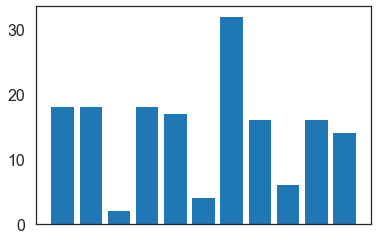

In [23]:
plt.bar(categories,ims_per_cat)
frame1=plt.gca()
frame1.axes.get_xaxis().set_visible(False)


In [36]:
X.draw_duration

0          0
1          0
2          0
3          0
4      7.187
5      9.259
6     11.744
7      6.833
8          0
9      4.209
10         0
11     1.659
12     5.142
13     9.343
14         0
15     8.892
16     0.008
17     0.026
18     0.032
19     0.035
20     0.534
21     1.189
22         0
23         0
Name: draw_duration, dtype: object

### load drawing metadata csv back in

### Basic visualizations

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'number of strokes')

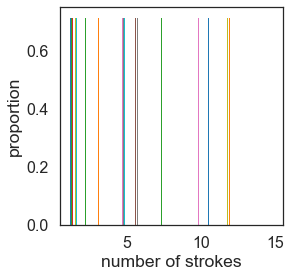

In [37]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'draw duration')

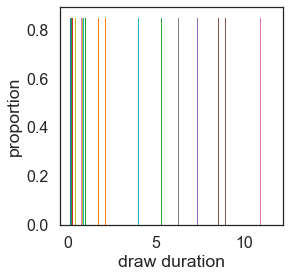

In [44]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

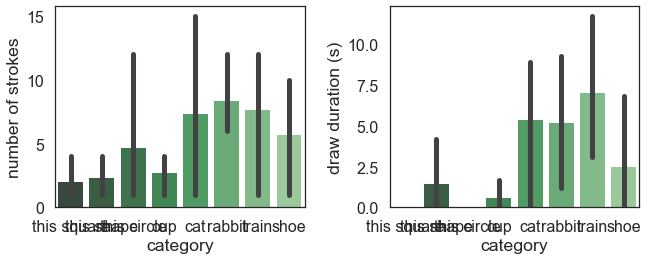

In [49]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
# seq = np.arange(4,10)
sns.barplot(data=X,x='category',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='category',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [ ]:
X.category

In [ ]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

In [ ]:
X.

In [ ]:
unique

In [ ]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat